In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro
from scipy.stats import zscore
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
# Read the CSV file
data = pd.read_csv("./kaggle/train_features.csv")

In [2]:
data.shape

(1749494, 57)

In [3]:
data.describe()

,building_id,meter_reading,anomaly,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
count,1.749494e+06,1.641841e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,...,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06,1.749494e+06
mean,7.908894e+02,1.799018e+02,2.131816e-02,7.819728e+00,1.065658e+05,1.925582e+02,1.002549e+00,1.650747e+01,1.169304e+02,8.809186e+00,...,4.116000e+00,4.116496e+00,4.116366e+00,4.115904e+00,4.315819e+00,4.205350e+00,4.261428e+00,4.315266e+00,4.315661e+00,4.314160e+00
std,4.118085e+02,3.959129e+02,1.444428e-01,4.830006e+00,1.025531e+05,8.934352e+01,2.237710e+00,1.032373e+01,1.263866e+02,9.871421e+00,...,1.243450e-14,1.172369e-01,7.456097e-02,4.426736e-02,1.360274e+00,3.888381e-01,6.918509e-01,1.380285e+00,1.365402e+00,1.367109e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.980000e+02,0.000000e+00,0.000000e+00,-2.990000e+01,0.000000e+00,-3.600000e+01,...,4.116000e+00,3.942000e+00,3.989000e+00,4.056000e+00,4.370000e-01,1.556000e+00,2.670000e+00,4.070000e-01,4.030000e-01,4.300000e-02
25%,3.450000e+02,3.000000e+01,0.000000e+00,3.000000e+00,3.182900e+04,8.200000e+01,0.000000e+00,9.100000e+00,0.000000e+00,2.000000e+00,...,4.116000e+00,4.009000e+00,4.012000e+00,4.078000e+00,3.537000e+00,4.211000e+00,4.090000e+00,3.522000e+00,3.539000e+00,3.536000e+00
50%,8.960000e+02,8.410000e+01,0.000000e+00,9.000000e+00,7.108800e+04,2.550000e+02,0.000000e+00,1.670000e+01,4.000000e+00,9.700000e+00,...,4.116000e+00,4.138000e+00,4.147000e+00,4.102000e+00,4.442000e+00,4.211000e+00,4.548000e+00,4.395000e+00,4.406000e+00,4.410000e+00
75%,1.147000e+03,1.990000e+02,0.000000e+00,1.300000e+01,1.383160e+05,2.550000e+02,0.000000e+00,2.440000e+01,2.550000e+02,1.670000e+01,...,4.116000e+00,4.244000e+00,4.173000e+00,4.162000e+00,5.238000e+00,4.489000e+00,4.662000e+00,5.270000e+00,5.238000e+00,5.262000e+00
max,1.353000e+03,6.596890e+03,1.000000e+00,1.500000e+01,4.843760e+05,2.550000e+02,1.200000e+01,4.720000e+01,2.550000e+02,2.610000e+01,...,4.116000e+00,4.265000e+00,4.176000e+00,4.186000e+00,8.424000e+00,4.891000e+00,7.270000e+00,8.576000e+00,8.493000e+00,8.458000e+00


In [4]:
data.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,NaN,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,NaN,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,NaN,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,NaN,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,NaN,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


In [5]:
mean_meter_reading = data['meter_reading'].median()

# Fill NaN values in the meter_reading column with the mean
data['meter_reading'] = data['meter_reading'].fillna(mean_meter_reading)

#check the first few rows to verify the changes
data.head()

,building_id,timestamp,meter_reading,anomaly,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,gte_meter,gte_meter_hour,gte_meter_weekday,gte_meter_month,gte_meter_building_id,gte_meter_primary_use,gte_meter_site_id,gte_meter_building_id_hour,gte_meter_building_id_weekday,gte_meter_building_id_month
0,1,2016-01-01 00:00:00,84.1,0,0,Education,2720,104,0,19.4,...,4.116,3.981,4.146,4.12,3.569,4.489,4.079,3.554,3.538,3.845
1,32,2016-01-01 00:00:00,84.1,0,0,Office,48392,105,0,19.4,...,4.116,3.981,4.146,4.12,4.513,4.211,4.079,4.128,4.579,4.317
2,41,2016-01-01 00:00:00,84.1,0,0,Office,93860,68,0,19.4,...,4.116,3.981,4.146,4.12,4.108,4.211,4.079,4.103,4.140,4.114
3,55,2016-01-01 00:00:00,84.1,0,0,Office,16726,111,0,19.4,...,4.116,3.981,4.146,4.12,3.506,4.211,4.079,3.308,3.565,3.813
4,69,2016-01-01 00:00:00,84.1,0,0,Parking,387638,100,0,19.4,...,4.116,3.981,4.146,4.12,3.035,3.623,4.079,3.892,3.090,3.577


In [6]:
ints = []
objects = []
floats = []

for col in data.columns:
    if data[col].dtype == 'int64':
        ints.append(col)
    elif data[col].dtype == object:
        objects.append(col)
    else:
        floats.append(col)

In [7]:
data = data.drop(['timestamp', 'year', 'gte_meter'], axis=1)

In [8]:
data = data.drop(objects[2:], axis=1)
print(data.shape)

(1749494, 48)


In [9]:
import numpy as np
import pandas as pd


def z_score_normalize_column(data, column_name):
    # Check if the column exists in the DataFrame
    if column_name in data.columns:
        # Apply log transformation to the specified column
        log_data = np.log1p(data[column_name])
        
        # Calculate mean and standard deviation for the column
        mean = log_data.mean()
        std_dev = log_data.std()
        
        # Perform z-score normalization for the column
        z_score_data = (log_data - mean) / std_dev
        
        # Replace the column in the DataFrame with the normalized data
        data[column_name] = z_score_data
    else:
        print(f"Column '{column_name}' not found in DataFrame.")
    
    return data

# Specify the column you want to normalize
column_to_normalize = 'meter_reading'

# Perform z-score normalization on the specified column
normalized_data = z_score_normalize_column(data, column_to_normalize)

# Display the normalized data
print(normalized_data)


         building_id  meter_reading  anomaly  site_id  \
0                  1       0.110187        0        0   
1                 32       0.110187        0        0   
2                 41       0.110187        0        0   
3                 55       0.110187        0        0   
4                 69       0.110187        0        0   
...              ...            ...      ...      ...   
1749489         1316      -0.421546        0       14   
1749490         1318       0.722439        0       14   
1749491         1319       0.110187        0       14   
1749492         1323       0.607311        0       14   
1749493         1353      -2.146115        0       15   

                           primary_use  square_feet  year_built  floor_count  \
0                            Education         2720         104            0   
1                               Office        48392         105            0   
2                               Office        93860          68            

In [10]:
data = normalized_data

array([[<Axes: title={'center': 'building_id'}>,
        <Axes: title={'center': 'meter_reading'}>,
        <Axes: title={'center': 'anomaly'}>,
        <Axes: title={'center': 'site_id'}>,
        <Axes: title={'center': 'square_feet'}>,
        <Axes: title={'center': 'year_built'}>,
        <Axes: title={'center': 'floor_count'}>],
       [<Axes: title={'center': 'air_temperature'}>,
        <Axes: title={'center': 'cloud_coverage'}>,
        <Axes: title={'center': 'dew_temperature'}>,
        <Axes: title={'center': 'precip_depth_1_hr'}>,
        <Axes: title={'center': 'sea_level_pressure'}>,
        <Axes: title={'center': 'wind_direction'}>,
        <Axes: title={'center': 'wind_speed'}>],
       [<Axes: title={'center': 'air_temperature_mean_lag7'}>,
        <Axes: title={'center': 'air_temperature_max_lag7'}>,
        <Axes: title={'center': 'air_temperature_min_lag7'}>,
        <Axes: title={'center': 'air_temperature_std_lag7'}>,
        <Axes: title={'center': 'air_tempera

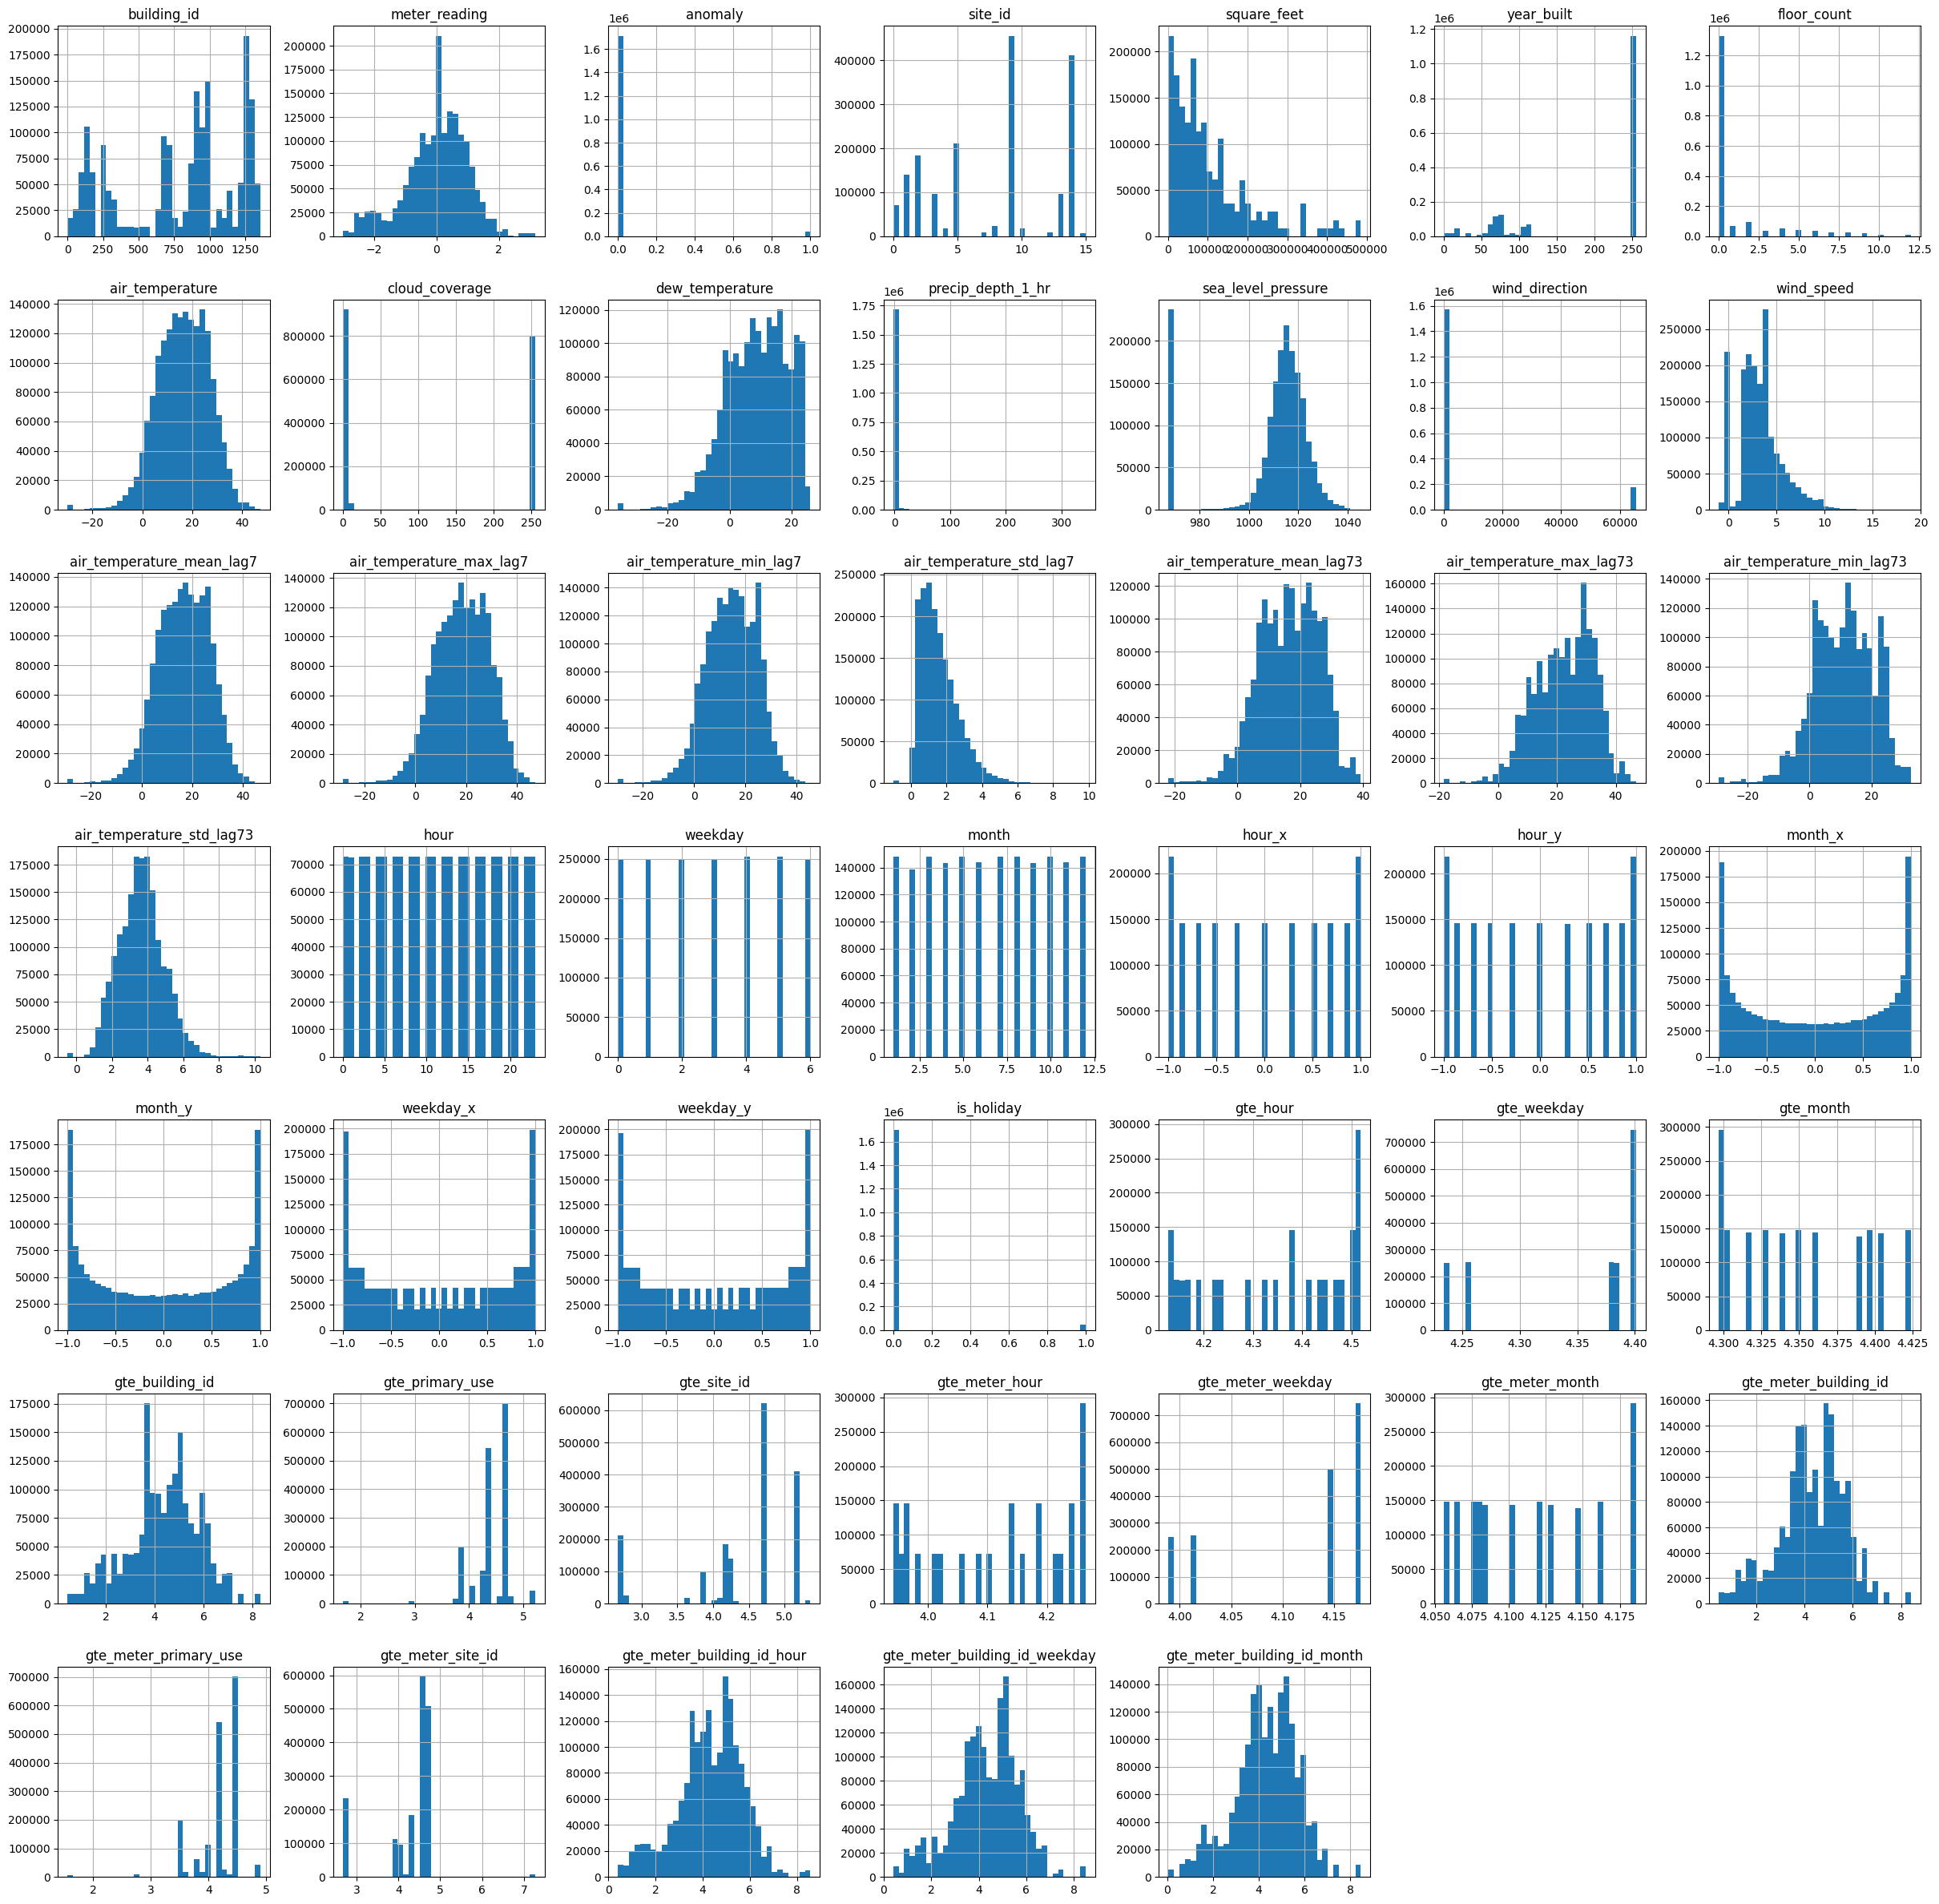

In [11]:
data.hist(bins=35, figsize=(30,30))

In [12]:
data.isnull().sum()

building_id                      0
meter_reading                    0
anomaly                          0
site_id                          0
primary_use                      0
square_feet                      0
year_built                       0
floor_count                      0
air_temperature                  0
cloud_coverage                   0
dew_temperature                  0
precip_depth_1_hr                0
sea_level_pressure               0
wind_direction                   0
wind_speed                       0
air_temperature_mean_lag7        0
air_temperature_max_lag7         0
air_temperature_min_lag7         0
air_temperature_std_lag7         0
air_temperature_mean_lag73       0
air_temperature_max_lag73        0
air_temperature_min_lag73        0
air_temperature_std_lag73        0
hour                             0
weekday                          0
month                            0
hour_x                           0
hour_y                           0
month_x             

In [13]:
# Assume df is your DataFrame
features = data.drop(columns=['meter_reading'])  # Adjust if 'target' is not the name of your target column

# Function to detect any cells containing strings
def contains_strings(column):
    return any(isinstance(x, str) for x in column)

# Identifying columns that contain strings
string_columns = [col for col in features.columns if features[col].dtype == 'object' or contains_strings(features[col])]

print("Columns containing strings:", string_columns)
data = data.drop(string_columns, axis=1)

Columns containing strings: ['primary_use']


In [14]:
from scipy.stats import pearsonr

features = data.drop(columns=['meter_reading'])
target = data['meter_reading']

# Convert all columns to numeric, coercing errors will turn non-convertible values to NaN
features = features.apply(pd.to_numeric, errors='coerce')
target = pd.to_numeric(target, errors='coerce')

# Calculating Pearson correlation
correlations = {}
for column in features.columns:
    correlation, _ = pearsonr(features[column], target)
    correlations[column] = abs(correlation)  # Use absolute value for sorting

# Converting to a DataFrame for better visualization
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Absolute Correlation with Target'])
correlation_df = correlation_df.sort_values(by='Absolute Correlation with Target', ascending=False)  # Sort by correlation
print(correlation_df)

                          Feature  Absolute Correlation with Target
45    gte_meter_building_id_month                          0.923366
43     gte_meter_building_id_hour                          0.920376
44  gte_meter_building_id_weekday                          0.912576
40          gte_meter_building_id                          0.908967
34                gte_building_id                          0.842344
3                     square_feet                          0.643066
42              gte_meter_site_id                          0.475395
36                    gte_site_id                          0.415603
10             sea_level_pressure                          0.322598
41          gte_meter_primary_use                          0.298449
35                gte_primary_use                          0.288026
20      air_temperature_std_lag73                          0.175612
1                         anomaly                          0.159304
2                         site_id               

In [15]:
data.shape

(1749494, 47)

In [16]:
# Set your thresholds here
correlation_threshold = 0.1

# Select features based on thresholds
selected_features_corr = correlation_df[correlation_df['Absolute Correlation with Target'] > correlation_threshold]['Feature']


print("Selected Features based on thresholds:")
print(selected_features_corr)

Selected Features based on thresholds:
45      gte_meter_building_id_month
43       gte_meter_building_id_hour
44    gte_meter_building_id_weekday
40            gte_meter_building_id
34                  gte_building_id
3                       square_feet
42                gte_meter_site_id
36                      gte_site_id
10               sea_level_pressure
41            gte_meter_primary_use
35                  gte_primary_use
20        air_temperature_std_lag73
1                           anomaly
2                           site_id
18        air_temperature_max_lag73
16         air_temperature_std_lag7
Name: Feature, dtype: object


In [17]:
features_to_keep = ['gte_meter_building_id_month',
'gte_meter_building_id_hour',
'gte_meter_building_id_weekday',
'gte_meter_building_id',
'gte_building_id',
'square_feet',
'gte_meter_site_id',
'gte_site_id',
'sea_level_pressure',
'gte_meter_primary_use',
'gte_primary_use',
'air_temperature_std_lag73',
'anomaly',
'site_id',
'meter_reading',
'air_temperature_std_lag7',
'air_temperature_max_lag73']

data = data[features_to_keep]

In [18]:
data.shape

(1749494, 17)

In [19]:
data['anomaly'].value_counts()

anomaly
0    1712198
1      37296
Name: count, dtype: int64

array([[<Axes: title={'center': 'gte_meter_building_id_month'}>,
        <Axes: title={'center': 'gte_meter_building_id_hour'}>,
        <Axes: title={'center': 'gte_meter_building_id_weekday'}>,
        <Axes: title={'center': 'gte_meter_building_id'}>],
       [<Axes: title={'center': 'gte_building_id'}>,
        <Axes: title={'center': 'square_feet'}>,
        <Axes: title={'center': 'gte_meter_site_id'}>,
        <Axes: title={'center': 'gte_site_id'}>],
       [<Axes: title={'center': 'sea_level_pressure'}>,
        <Axes: title={'center': 'gte_meter_primary_use'}>,
        <Axes: title={'center': 'gte_primary_use'}>,
        <Axes: title={'center': 'air_temperature_std_lag73'}>],
       [<Axes: title={'center': 'anomaly'}>,
        <Axes: title={'center': 'site_id'}>,
        <Axes: title={'center': 'meter_reading'}>,
        <Axes: title={'center': 'air_temperature_std_lag7'}>],
       [<Axes: title={'center': 'air_temperature_max_lag73'}>, <Axes: >,
        <Axes: >, <Axes: >]]

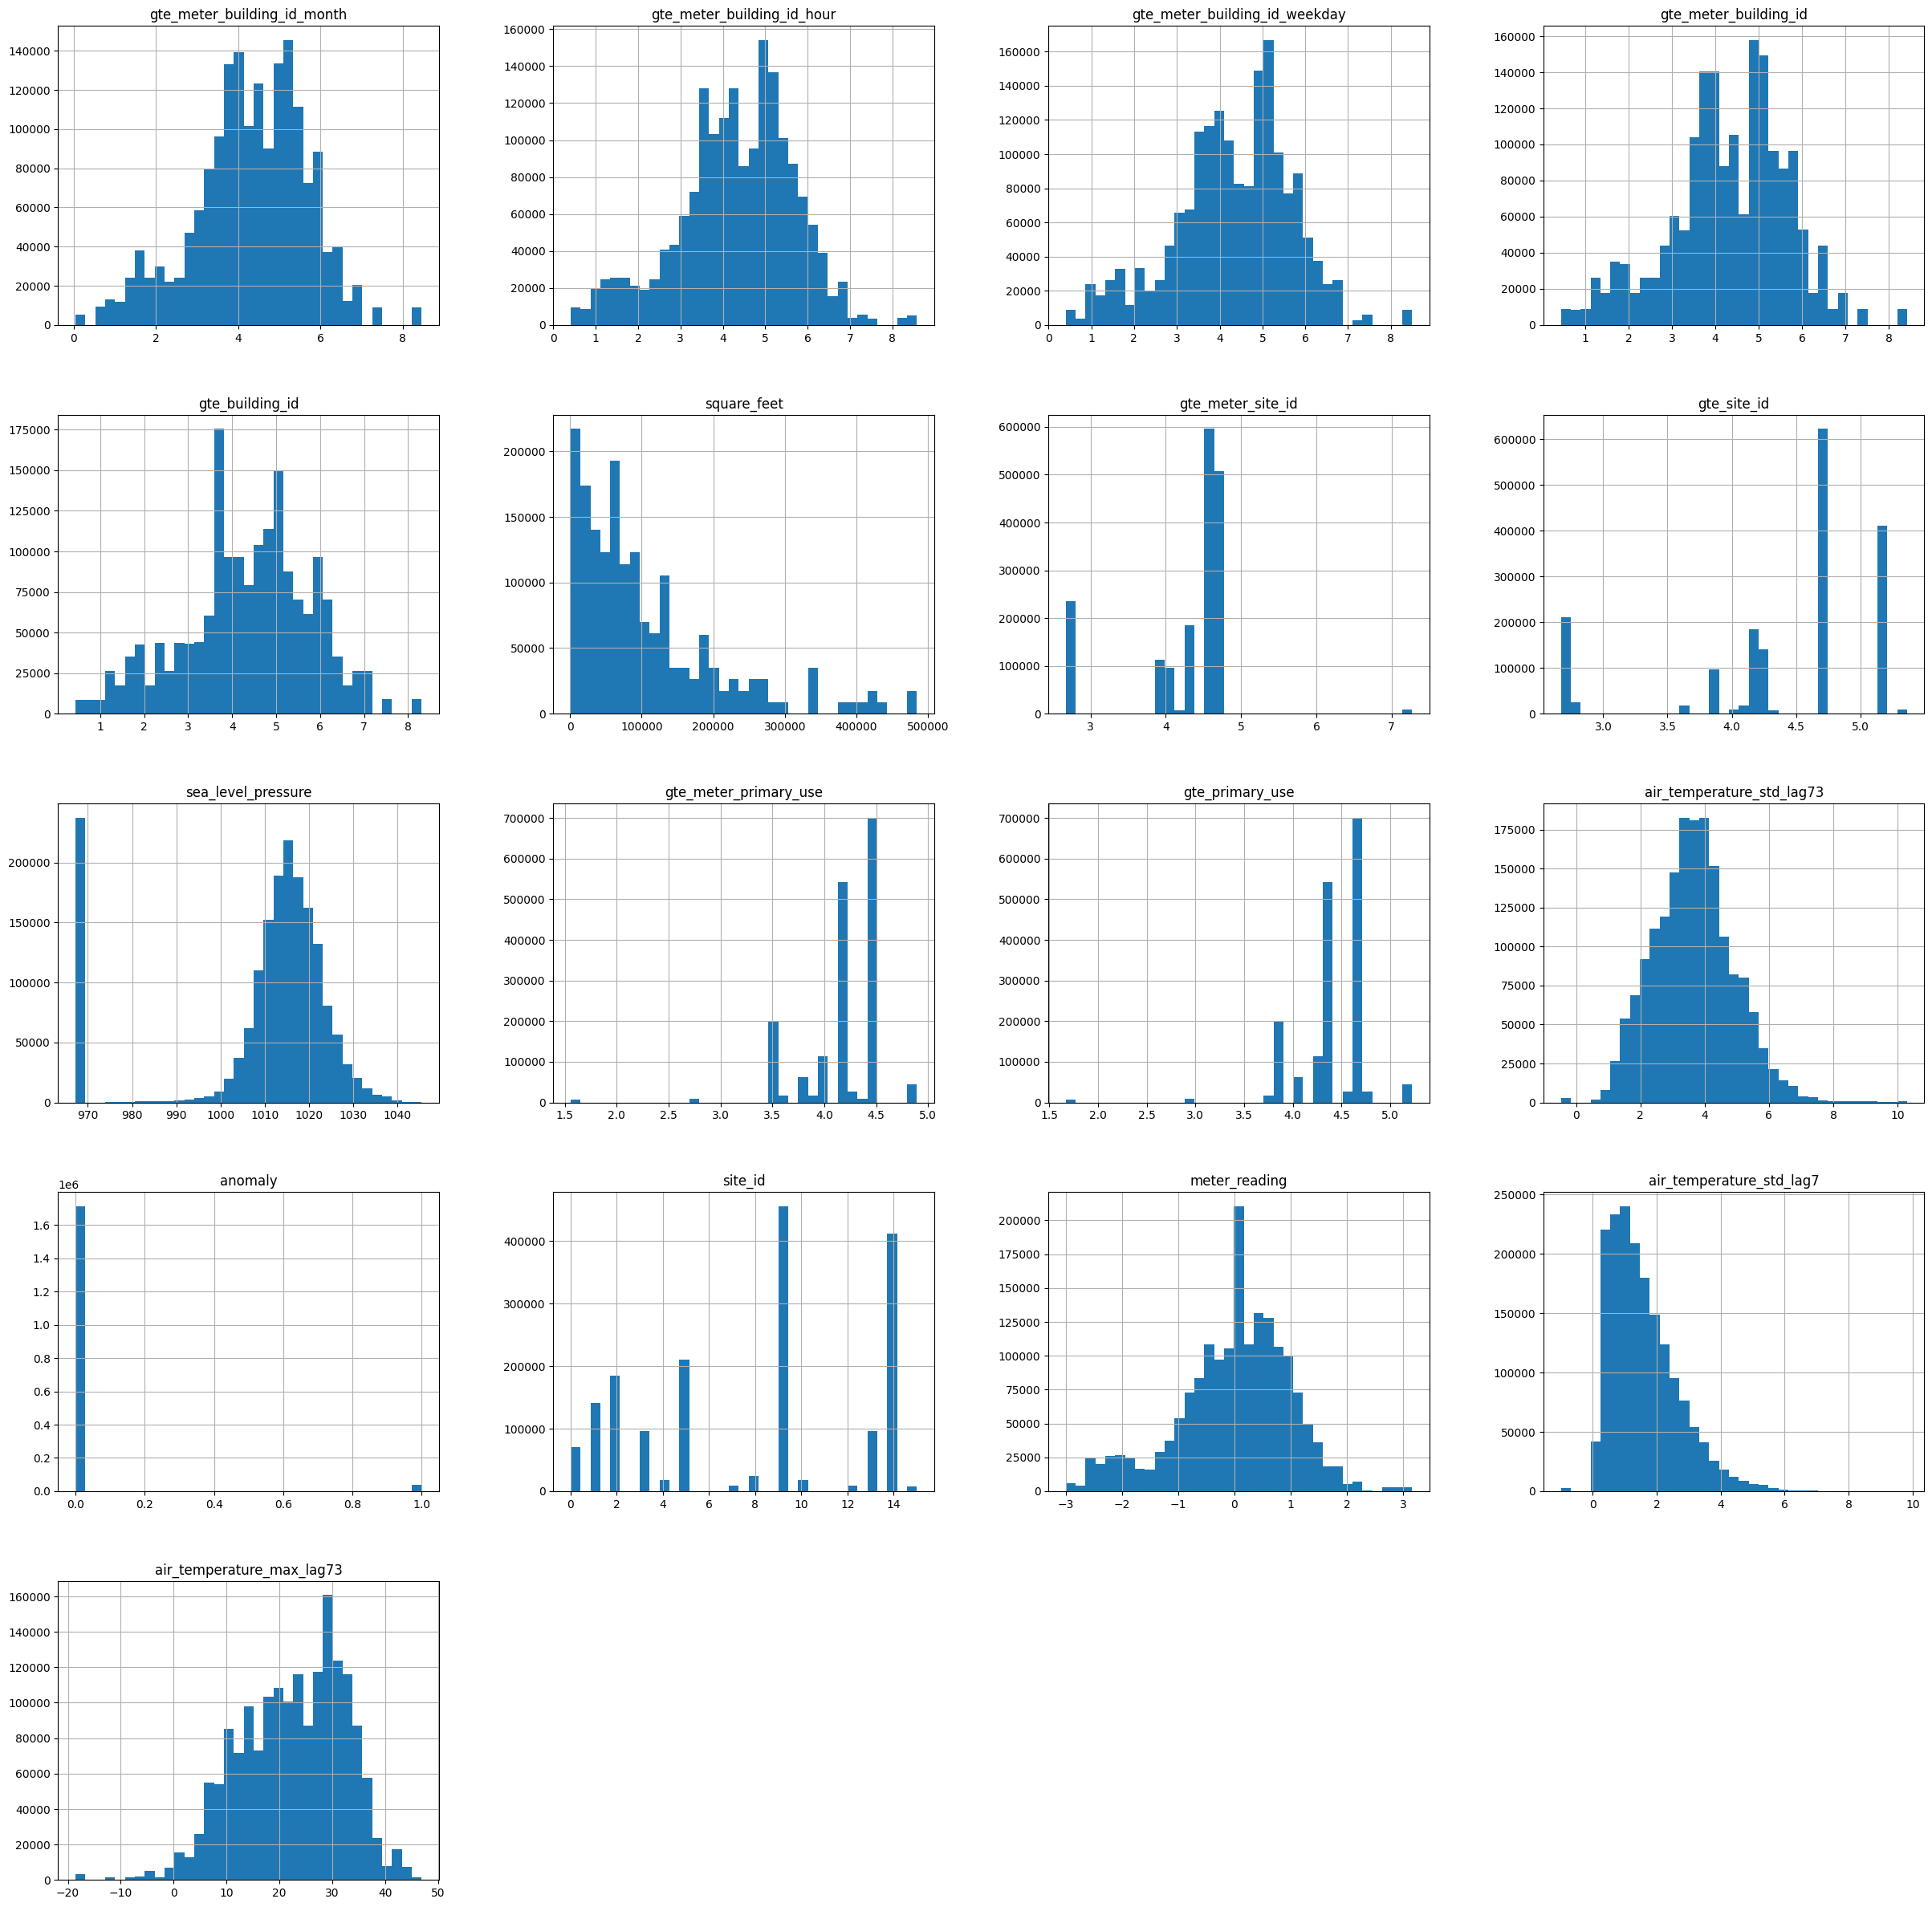

In [20]:
data.hist(bins=35, figsize=(30,30))

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

# Assuming data is loaded correctly
# data = pd.read_csv('your_data.csv')
X = data.drop(['anomaly'], axis=1, errors='ignore')
y = data['anomaly']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
ros = RandomOverSampler(random_state=42)

In [22]:
X.shape, y.shape

((1749494, 16), (1749494,))

In [23]:
print(X.columns)

Index(['gte_meter_building_id_month', 'gte_meter_building_id_hour',
       'gte_meter_building_id_weekday', 'gte_meter_building_id',
       'gte_building_id', 'square_feet', 'gte_meter_site_id', 'gte_site_id',
       'sea_level_pressure', 'gte_meter_primary_use', 'gte_primary_use',
       'air_temperature_std_lag73', 'site_id', 'meter_reading',
       'air_temperature_std_lag7', 'air_temperature_max_lag73'],
      dtype='object')


In [24]:
# Run cross-validation
scores = []
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Manually apply oversampling to both the training and testing data
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

    # Define and train the Logistic Regression model
    model = LogisticRegression()
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_resampled)
    scores.append(accuracy_score(y_test_resampled, y_pred))

    # Store accuracy scores and generate reports
    print("Fold Accuracy:", accuracy_score(y_test_resampled, y_pred))
    print("Classification Report for current fold:")
    print(classification_report(y_test_resampled, y_pred))

# Display average results
print("Average Validation Accuracy for Logistic Regression:", np.mean(scores))


Fold Accuracy: 0.7393454832208884
Classification Report for current fold:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78    342390
           1       0.88      0.55      0.68    342390

    accuracy                           0.74    684780
   macro avg       0.78      0.74      0.73    684780
weighted avg       0.78      0.74      0.73    684780

Fold Accuracy: 0.7423729753716442
Classification Report for current fold:
              precision    recall  f1-score   support

           0       0.68      0.93      0.78    342532
           1       0.88      0.56      0.68    342532

    accuracy                           0.74    685064
   macro avg       0.78      0.74      0.73    685064
weighted avg       0.78      0.74      0.73    685064

Fold Accuracy: 0.7376141084289163
Classification Report for current fold:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78    342547
           1   

LR-Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78    342399
           1       0.88      0.54      0.67    342399

    accuracy                           0.74    684798
   macro avg       0.78      0.74      0.73    684798
weighted avg       0.78      0.74      0.73    684798

LR-Confusion Matrix:


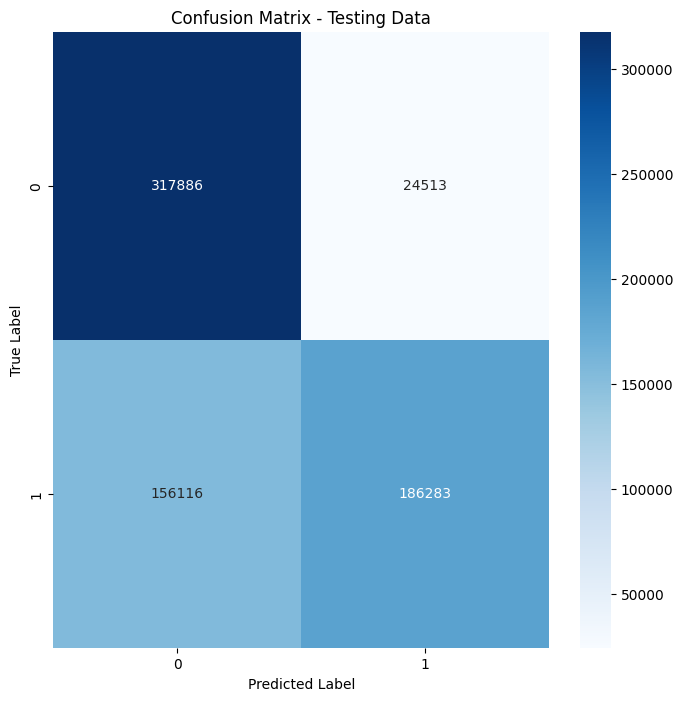

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Print the classification report and confusion matrix
print("LR-Classification Report:")
print(classification_report(y_test_resampled, y_pred))
print("LR-Confusion Matrix:")
conf_matrix_test = confusion_matrix(y_test_resampled, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Testing Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [26]:
tn, fp , fn , tp = conf_matrix_test.ravel()
print('Accuracy = ', (tp + tn) / (tn + fn + fp + tp))
print('Precision = ', tp / (fp + tp))
print('Recall = ', tp / (fn + tp))
print('F1-score = ', 2 * tp / (2 * tp + fn + fp))

Accuracy =  0.7362302459995502
Precision =  0.8837122146530295
Recall =  0.544052406695113
F1-score =  0.6734804182973454


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler

# Use all columns except 'anomaly' as features
X = data.drop('anomaly', axis=1).values
y = data['anomaly'].values

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # Reshape for LSTM

# Set up KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Initialize metrics storage
fold_metrics = {
    'auc_train': [],
    'auc_test': [],
    'accuracy_train': [],
    'accuracy_test': []
}

all_y_test = []
all_y_pred = []

# K-fold cross-validation
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Oversampling the training data
    X_train_reshaped = X_train.reshape(-1, X_train.shape[2])  # Flatten for oversampling
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_reshaped, y_train)
    X_train_resampled = X_train_resampled.reshape(-1, 1, X_train.shape[2])  # Reshape back to 3D

    # Oversampling the testing data
    X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
    X_test_resampled, y_test_resampled = ros.fit_resample(X_test_reshaped, y_test)
    X_test_resampled = X_test_resampled.reshape(-1, 1, X_test.shape[2])

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, X_train_resampled.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train model
    model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, verbose=1)

    # Predicting
    y_train_pred = (model.predict(X_train_resampled) > 0.5).astype(int)
    y_test_pred = (model.predict(X_test_resampled) > 0.5).astype(int)

    # Collect predictions and true labels
    all_y_test.extend(y_test_resampled)
    all_y_pred.extend(y_test_pred.flatten())

    # Evaluating
    train_auc = roc_auc_score(y_train_resampled, y_train_pred)
    test_auc = roc_auc_score(y_test_resampled, y_test_pred)
    train_acc = accuracy_score(y_train_resampled, y_train_pred)
    test_acc = accuracy_score(y_test_resampled, y_test_pred)

    # Store metrics
    fold_metrics['auc_train'].append(train_auc)
    fold_metrics['auc_test'].append(test_auc)
    fold_metrics['accuracy_train'].append(train_acc)
    fold_metrics['accuracy_test'].append(test_acc)

    # Print classification report for the current fold
    print(f"Classification Report for Fold (Test Data):")
    print(classification_report(y_test_resampled, y_test_pred))
    print()

# Calculate and print average and standard deviation for each metric
for key, values in fold_metrics.items():
    print(f"{key} - Average: {np.mean(values):.4f}, StdDev: {np.std(values):.4f}")

# Final Evaluation
print("Final Test Classification Report:")
print(classification_report(all_y_test, all_y_pred))


c:\Users\Abdullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.7996 - loss: 0.4145
Epoch 2/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 58s 1ms/step - accuracy: 0.8640 - loss: 0.3077
Epoch 3/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - accuracy: 0.8771 - loss: 0.2820
Epoch 4/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - accuracy: 0.8840 - loss: 0.2677
Epoch 5/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8891 - loss: 0.2575
Epoch 6/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.8924 - loss: 0.2509
Epoch 7/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step - accuracy: 0.8950 - loss: 0.2449
Epoch 8/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - accuracy: 0.8968 - loss: 0.2404
Epoch 9/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - accuracy: 0.8987 - loss: 0.2362
Epoch 10/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - accuracy: 0.8999 - loss: 0.2336
85613/85613 ━━━━━━━━━━━━━━━━━━━━ 77s 902us/step
21400/21400 ━━━━━━━━━━━━━━━━━━━━ 20s 910u

c:\Users\Abdullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 65s 1ms/step - accuracy: 0.8020 - loss: 0.4141
Epoch 2/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - accuracy: 0.8616 - loss: 0.3119
Epoch 3/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step - accuracy: 0.8738 - loss: 0.2862
Epoch 4/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step - accuracy: 0.8818 - loss: 0.2695
Epoch 5/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - accuracy: 0.8881 - loss: 0.2571
Epoch 6/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - accuracy: 0.8918 - loss: 0.2490
Epoch 7/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8950 - loss: 0.2432
Epoch 8/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8973 - loss: 0.2381
Epoch 9/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.8994 - loss: 0.2339
Epoch 10/10
42803/42803 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step - accuracy: 0.9008 - loss: 0.2310
85605/85605 ━━━━━━━━━━━━━━━━━━━━ 79s 918us/step
21409/21409 ━━━━━━━━━━━━━━━━━━━━ 20s 919u

c:\Users\Abdullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 65s 1ms/step - accuracy: 0.7999 - loss: 0.4145
Epoch 2/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 60s 1ms/step - accuracy: 0.8608 - loss: 0.3163
Epoch 3/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step - accuracy: 0.8738 - loss: 0.2885
Epoch 4/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - accuracy: 0.8817 - loss: 0.2718
Epoch 5/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 59s 1ms/step - accuracy: 0.8865 - loss: 0.2617
Epoch 6/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.8904 - loss: 0.2529
Epoch 7/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.8932 - loss: 0.2474
Epoch 8/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8950 - loss: 0.2429
Epoch 9/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8970 - loss: 0.2391
Epoch 10/10
42802/42802 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.8984 - loss: 0.2361
85604/85604 ━━━━━━━━━━━━━━━━━━━━ 80s 932us/step
21410/21410 ━━━━━━━━━━━━━━━━━━━━ 19s 872u

c:\Users\Abdullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.8001 - loss: 0.4155
Epoch 2/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8613 - loss: 0.3145
Epoch 3/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.8737 - loss: 0.2895
Epoch 4/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step - accuracy: 0.8803 - loss: 0.2750
Epoch 5/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 60s 1ms/step - accuracy: 0.8851 - loss: 0.2644
Epoch 6/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8886 - loss: 0.2571
Epoch 7/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.8913 - loss: 0.2515
Epoch 8/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 61s 1ms/step - accuracy: 0.8931 - loss: 0.2468
Epoch 9/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 60s 1ms/step - accuracy: 0.8947 - loss: 0.2425
Epoch 10/10
42809/42809 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.8959 - loss: 0.2402
85617/85617 ━━━━━━━━━━━━━━━━━━━━ 82s 951us/step
21396/21396 ━━━━━━━━━━━━━━━━━━━━ 20s 937u

c:\Users\Abdullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 74s 2ms/step - accuracy: 0.8011 - loss: 0.4154
Epoch 2/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.8648 - loss: 0.3082
Epoch 3/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.8796 - loss: 0.2777
Epoch 4/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.8878 - loss: 0.2609
Epoch 5/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - accuracy: 0.8923 - loss: 0.2516
Epoch 6/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.8954 - loss: 0.2441
Epoch 7/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step - accuracy: 0.8979 - loss: 0.2383
Epoch 8/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.8996 - loss: 0.2341
Epoch 9/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step - accuracy: 0.9011 - loss: 0.2302
Epoch 10/10
42807/42807 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.9021 - loss: 0.2275
85613/85613 ━━━━━━━━━━━━━━━━━━━━ 78s 905us/step
21400/21400 ━━━━━━━━━━━━━━━━━━━━ 20s 953u

LSTM-Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89   1712198
           1       0.91      0.86      0.89   1712198

    accuracy                           0.89   3424396
   macro avg       0.89      0.89      0.89   3424396
weighted avg       0.89      0.89      0.89   3424396

LSTM-Confusion Matrix:


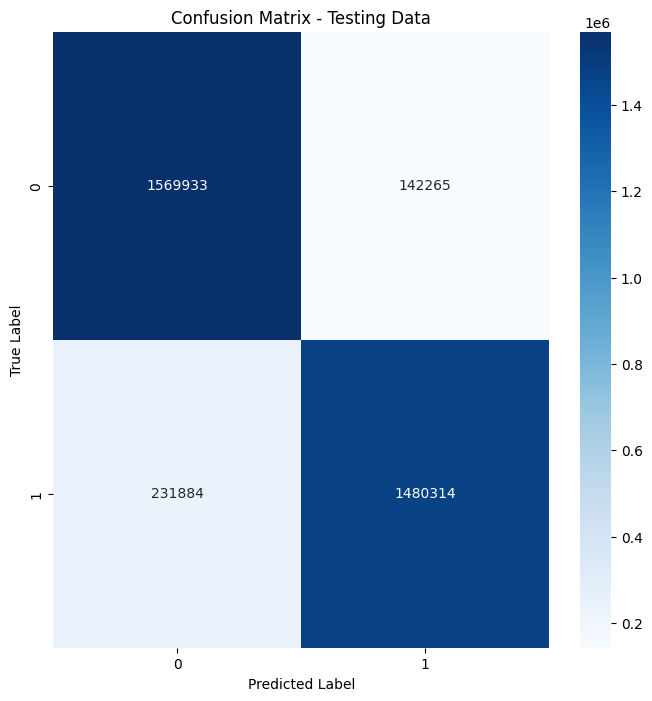

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print the classification report and confusion matrix
print("LSTM-Classification Report:")
print(classification_report(all_y_test, all_y_pred))
print("LSTM-Confusion Matrix:")
conf_matrix_test = confusion_matrix(all_y_test, all_y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Testing Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [29]:
tn, fp , fn , tp = conf_matrix_test.ravel()
print('Accuracy = ', (tp + tn) / (tn + fn + fp + tp))
print('Precision = ', tp / (fp + tp))
print('Recall = ', tp / (fn + tp))
print('F1-score = ', 2 * tp / (2 * tp + fn + fp))

Accuracy =  0.8907401480436258
Precision =  0.9123216804852029
Recall =  0.8645694014360489
F1-score =  0.8878038921343167


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

# Assuming data is your DataFrame
# data = pd.read_csv('your_data.csv')
X = data.drop(['anomaly'], axis=1, errors='ignore')
y = data['anomaly']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up KFold
kf = KFold(n_splits=10, random_state=42, shuffle=True)
ros = RandomOverSampler(random_state=42)

# Run cross-validation
scores = []
all_y_test = []
all_y_pred = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Manually apply oversampling to both the training and testing data
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

    # Define the XGBClassifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_resampled)
    scores.append(accuracy_score(y_test_resampled, y_pred))

    # Collect predictions for final evaluation
    all_y_test.extend(y_test_resampled)
    all_y_pred.extend(y_pred)

    # Print classification report for current fold
    print("Classification Report for current fold:")
    print(classification_report(y_test_resampled, y_pred))

# Display average results
print("Average Validation Accuracy for XGBClassifier:", np.mean(scores))
print("Final Classification Report for XGBClassifier:")
print(classification_report(all_y_test, all_y_pred))


Classification Report for current fold:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    171165
           1       0.97      0.90      0.94    171165

    accuracy                           0.94    342330
   macro avg       0.94      0.94      0.94    342330
weighted avg       0.94      0.94      0.94    342330

Classification Report for current fold:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    171226
           1       0.97      0.90      0.94    171226

    accuracy                           0.94    342452
   macro avg       0.94      0.94      0.94    342452
weighted avg       0.94      0.94      0.94    342452

Classification Report for current fold:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    171265
           1       0.97      0.90      0.93    171265

    accuracy                           0.94    342530
   macro

XGBClassifier-Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94   1712198
           1       0.97      0.90      0.93   1712198

    accuracy                           0.94   3424396
   macro avg       0.94      0.94      0.94   3424396
weighted avg       0.94      0.94      0.94   3424396

XGBClassifier-Confusion Matrix:


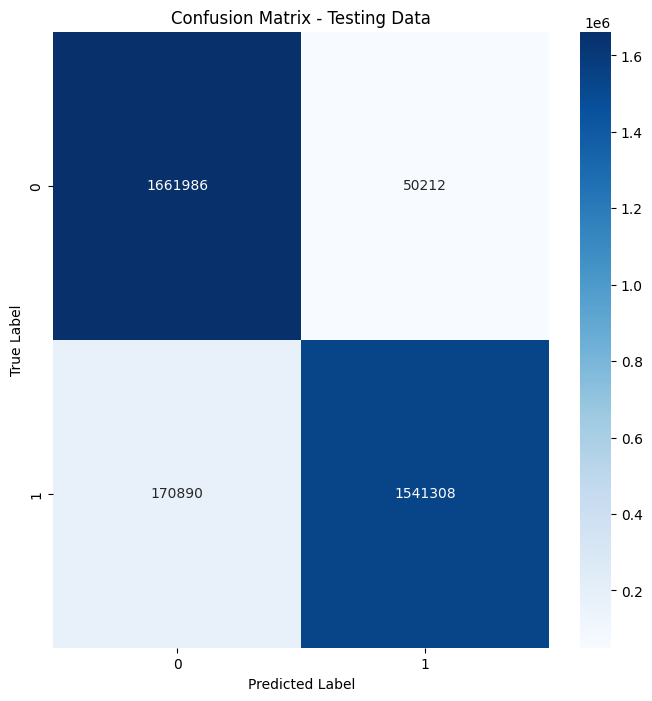

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Print the classification report and confusion matrix
print("XGBClassifier-Classification Report:")
print(classification_report(all_y_test, all_y_pred))
print("XGBClassifier-Confusion Matrix:")
conf_matrix_test = confusion_matrix(all_y_test, all_y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Testing Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [32]:
tn, fp, fn, tp = conf_matrix_test.ravel()
print('Accuracy = ', (tp + tn) / (tn + fn + fp + tp))
print('Precision = ', tp / (fp + tp))
print('Recall = ', tp / (fn + tp))
print('F1-score = ', 2 * tp / (2 * tp + fn + fp))

Accuracy =  0.9354332851691218
Precision =  0.9684502865185483
Recall =  0.9001926179098445
F1-score =  0.9330747963355226


Fold metrics for CBLOF:
Test ROC AUC Score: 0.5199770462978975
Test Accuracy: 0.5007551083003491
Test Data Evaluation for current fold:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67    342335
           1       0.57      0.01      0.01    342335

    accuracy                           0.50    684670
   macro avg       0.53      0.50      0.34    684670
weighted avg       0.53      0.50      0.34    684670


Fold metrics for CBLOF:
Test ROC AUC Score: 0.5446839576011129
Test Accuracy: 0.5002306704041112
Test Data Evaluation for current fold:
              precision    recall  f1-score   support

           0       0.50      0.99      0.67    342480
           1       0.52      0.01      0.01    342480

    accuracy                           0.50    684960
   macro avg       0.51      0.50      0.34    684960
weighted avg       0.51      0.50      0.34    684960


Fold metrics for CBLOF:
Test ROC AUC Score: 0.5138543687212577
Test Accu

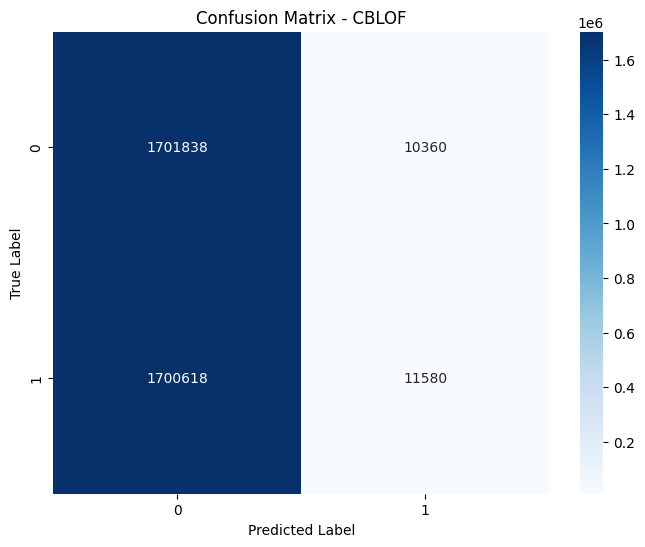

Fold metrics for HBOS:
Test ROC AUC Score: 0.4552525962806132
Test Accuracy: 0.48702586647582047
Test Data Evaluation for current fold:
              precision    recall  f1-score   support

           0       0.49      0.88      0.63    342335
           1       0.44      0.10      0.16    342335

    accuracy                           0.49    684670
   macro avg       0.47      0.49      0.39    684670
weighted avg       0.47      0.49      0.39    684670


Fold metrics for HBOS:
Test ROC AUC Score: 0.45448910358504746
Test Accuracy: 0.48642402476056995
Test Data Evaluation for current fold:
              precision    recall  f1-score   support

           0       0.49      0.88      0.63    342480
           1       0.44      0.10      0.16    342480

    accuracy                           0.49    684960
   macro avg       0.46      0.49      0.39    684960
weighted avg       0.46      0.49      0.39    684960


Fold metrics for HBOS:
Test ROC AUC Score: 0.46182921869083293
Test Acc

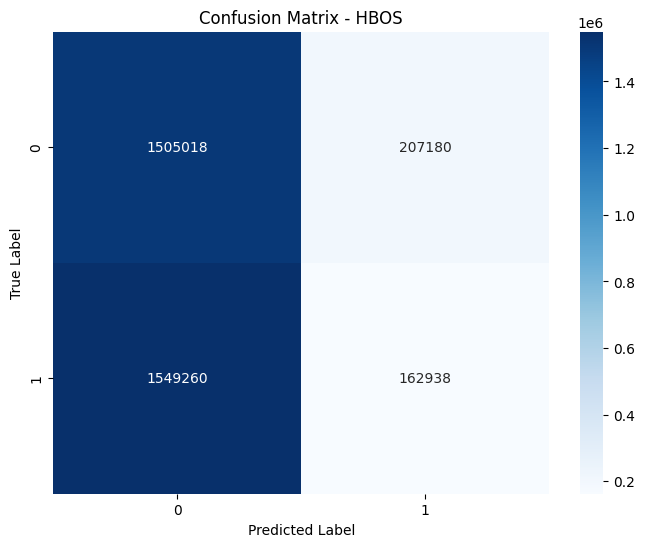

Fold metrics for IForest:
Test ROC AUC Score: 0.5136173862803644
Test Accuracy: 0.4992565761607782
Test Data Evaluation for current fold:
              precision    recall  f1-score   support

           0       0.50      0.91      0.65    342335
           1       0.50      0.09      0.15    342335

    accuracy                           0.50    684670
   macro avg       0.50      0.50      0.40    684670
weighted avg       0.50      0.50      0.40    684670


Fold metrics for IForest:
Test ROC AUC Score: 0.5150074140514213
Test Accuracy: 0.5012818266760103
Test Data Evaluation for current fold:
              precision    recall  f1-score   support

           0       0.50      0.91      0.65    342480
           1       0.51      0.09      0.16    342480

    accuracy                           0.50    684960
   macro avg       0.50      0.50      0.40    684960
weighted avg       0.50      0.50      0.40    684960


Fold metrics for IForest:
Test ROC AUC Score: 0.5122752620093618
Tes

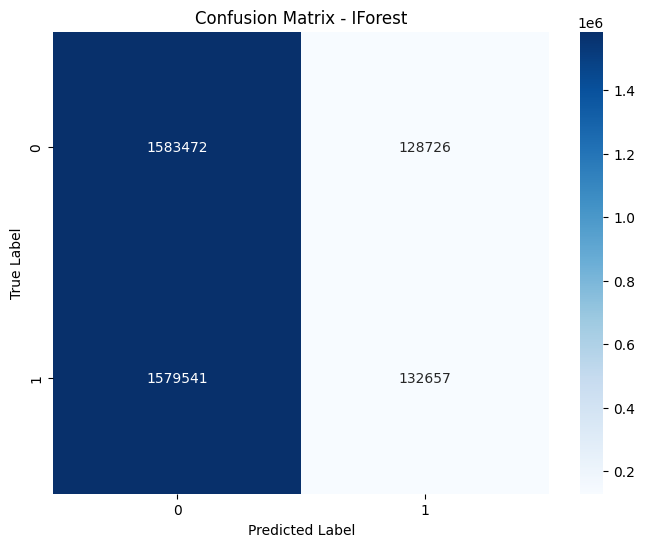

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up KFold and oversampler
kf = KFold(n_splits=5, random_state=5, shuffle=True)
ros = RandomOverSampler(random_state=5)

# Setting up all models
models = [
    CBLOF(contamination=0.1),
    #FeatureBagging(base_estimator=KNN(), contamination=0.1),
    #KNN(),
    HBOS(contamination=0.1),
    IForest(contamination=0.1),
    #OCSVM(contamination=0.1),
    #LOF(contamination=0.1),
    #MCD(contamination=0.1)
]

# Loop to train and evaluate each model
for model in models:
    auc_scores_test = []
    accuracy_scores_test = []
    all_y_test = []
    all_y_pred = []

    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Oversampling the training and test data
        X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
        X_test_resampled, y_test_resampled = ros.fit_resample(X_test, y_test)

        model.fit(X_train_resampled)

        # Predict and evaluate the model
        if hasattr(model, 'predict_proba'):
            y_test_probs = model.predict_proba(X_test_resampled)[:, 1]
            y_test_pred = (y_test_probs >= 0.5).astype(int)
        else:
            y_test_scores = model.decision_function(X_test_resampled)
            y_test_probs = (y_test_scores - y_test_scores.min()) / (y_test_scores.max() - y_test_scores.min())
            y_test_pred = (y_test_probs >= 0.5).astype(int)

        # Collect all test predictions and true labels
        all_y_test.extend(y_test_resampled)
        all_y_pred.extend(y_test_pred)

        # Calculate metrics
        test_auc = roc_auc_score(y_test_resampled, y_test_probs)
        test_acc = accuracy_score(y_test_resampled, y_test_pred)
        auc_scores_test.append(test_auc)
        accuracy_scores_test.append(test_acc)

        # Print classification report for the current fold
        print(f'Fold metrics for {model.__class__.__name__}:')
        print('Test ROC AUC Score:', test_auc)
        print('Test Accuracy:', test_acc)
        print("Test Data Evaluation for current fold:")
        print(classification_report(y_test_resampled, y_test_pred))
        print()

    # Print average scores from all folds
    print(f'Average Test ROC AUC Score for {model.__class__.__name__}:', np.mean(auc_scores_test))
    print(f'Average Test Accuracy for {model.__class__.__name__}:', np.mean(accuracy_scores_test))
    # Print the classification report and confusion matrix for each model after all folds
    print("Classification Report for all folds:")
    print(classification_report(all_y_test, all_y_pred))
    print("Confusion Matrix for all folds:")
    conf_matrix_test = confusion_matrix(all_y_test, all_y_pred)

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
